# Logisitc and exponential growth models of UK Covid-19 confirmed cases data

Date: 2020-04-19

Version: 20.04.19

Author: Andrew Lane

DISCLAIMER: I am not an epidemiologist or doctor. Just an curious guy with a laptop and access to some data. Do not use the contents of this notebook for anything.

In [1]:
from collections import namedtuple
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from sympy import Symbol, symbols, exp

font = {'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
FigSize = namedtuple('DefaultFigSize', ['width_in', 'height_in'])
default_figsize = FigSize(width_in=7, height_in=4)
tall_figsize = FigSize(width_in=7, height_in=8)

In [3]:
PLOT_DIR = Path('plots')
PLOT_DIR.mkdir(exist_ok=True)

## Prepare data

The data used in this notebook come from a collated source on [GitHub](https://github.com/tomwhite/covid-19-uk-data)

In [4]:
SRC_DATA = ("https://raw.githubusercontent.com/tomwhite/covid-19-uk-data"
            "/master/data/covid-19-totals-uk.csv")

UK_POP = 63182000
UK_LOCKDOWN_DATE = '2020-03-23'

In [5]:
df = (
    pd.read_csv(SRC_DATA)
    .assign(date=lambda df: pd.to_datetime(df['Date']))
    .drop(columns='Date')
    .set_index('date')
    .rename(columns={'Tests': 'tests', 'ConfirmedCases': 'total_cases'})
    .drop(columns='Deaths')
)

assert df.index.is_unique

In [6]:
df.head(10)

,tests,total_cases
date,,
2020-01-25,31,0
2020-01-26,52,0
2020-01-27,73,0
2020-01-28,97,0
2020-01-29,130,0
2020-01-30,161,0
2020-01-31,177,2
2020-02-01,203,2
2020-02-02,266,2


Calculate new cases on each day

In [7]:
df = df.assign(new_cases=lambda df: df['total_cases'].diff())

Consider dates from the first confirmed case

In [8]:
df = df.loc['2020-01-31':]

Create a column `n_days` to report number of days since first confirmed case

In [9]:
df = df.assign(n_days=range(len(df.index)))

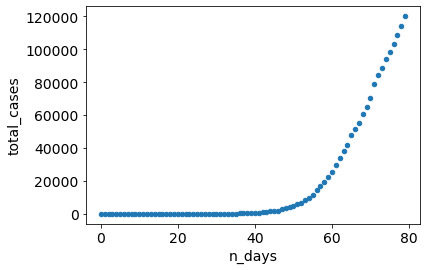

In [10]:
df.plot.scatter(x='n_days', y='total_cases')

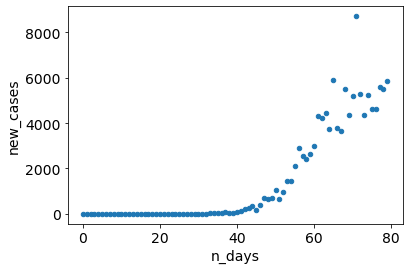

In [11]:
df.plot.scatter(x='n_days', y='new_cases')

Histogram of daily new cases

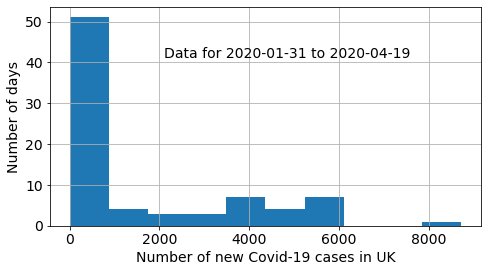

In [12]:
fig, ax = plt.subplots(figsize=default_figsize)
df['new_cases'].hist(ax=ax, bins=10)
ax.set_ylabel('Number of days')
ax.set_xlabel('Number of new Covid-19 cases in UK')
ax.annotate(f'Data for {df.iloc[0].name.date()} to {df.iloc[-1].name.date()}',
            (2100, 41))
plt.tight_layout()
plt.savefig(PLOT_DIR / 'num_cases_histogram.png')

See [Appendix A](#appendix-a) for a brief discussion of difficulties associated with modelling the distribution of daily new cases.

## Fit logistic growth model

In this section we attempt to model the cumulative total number of cases using a logistic function, defined by

$$X_t = f(t) = \frac{a}{1 + e^{-k(t - t_0)}}$$

Represent symbolically:

In [13]:
t, k, a, t0 = symbols('t k a t0')
f = a / (1 + exp(-k*(t - t0)))

In [14]:
f

a/(1 + exp(-k*(t - t0)))

We implement the function to model the growth in cumulative number of cases in `logistic_func`

In [15]:
def logistic_func(t: float, t0: float, a: float, k: float) -> float:
    """Logistic function.
    
    f(t) = \frac{a}{1 + e^{-k(t - t_0)}}
    
    Parameters
    ----------
    t: time of observation
    t0: t value of sigmoid midpoint
    a: curve's maximum value
    k: logistic growth rate
    """
    return a / (1 + np.exp(-k * (t - t0)))

logistic_func_v = np.vectorize(logistic_func, excluded=['t0', 'a', 'k'])

Note that if the cumulative total number of cases, $X_t$ is modelled by $f(t)$, this implies the number of daily new cases $x_t$ is modelled by $f'(t)$ with the same model fit parameters.

$$x_t = f'(t) = \frac{a k e^{- k \left(t - t_{0}\right)}}{\left(1 + e^{- k \left(t - t_{0}\right)}\right)^{2}}$$

In [16]:
f.diff(t)

a*k*exp(-k*(t - t0))/(1 + exp(-k*(t - t0)))**2

We implement the logistic model of daily change in `diff_logistic_func`

In [17]:
def diff_logistic_func(t: float, t0: float, a: float, k: float) -> float:
    """1st derivative of logistic function.
    
    f'(t) = a*k*exp(-k*(t - t0))/(1 + exp(-k*(t - t0)))**2

    Parameters
    ----------
    t: time of observation
    t0: t value of sigmoid midpoint
    a: curve's maximum value
    k: logistic growth rate
    """
    def exp_factor(t, k, t0):
        return np.exp(-k * (t - t0))
    
    return ((a * k * exp_factor(t, k, t0))
            / np.power(1 + exp_factor(t, k, t0), 2))

diff_logistic_func_v = np.vectorize(diff_logistic_func,
                                    excluded=['t0', 'a', 'k'])

Test implementation of `logistic_func` and `diff_logistic_func` by checking a plot made using the function looks correct. We expect midpoint of curve to be at x=50 and the maximum point to be 5.

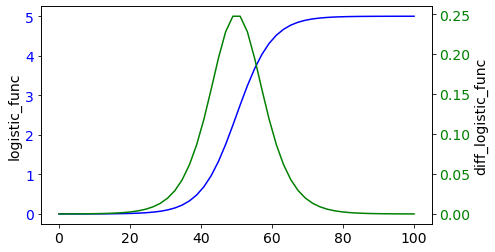

In [18]:
fig, ax1 = plt.subplots(figsize=default_figsize)
tt = np.linspace(0, 100)
yy = logistic_func_v(tt, t0=50, a=5, k=0.2)
diff_yy = diff_logistic_func_v(tt, t0=50, a=5, k=0.2)

color = 'b'
ax1.plot(tt, yy, color=color)
ax1.set_ylabel('logistic_func')
ax1.tick_params(axis='y', labelcolor=color)

color = 'g'
ax2 = ax1.twinx()
ax2.plot(tt, diff_yy, color=color)
ax2.set_ylabel('diff_logistic_func')
ax2.tick_params(axis='y', labelcolor=color)

Find optimal model parameters to fit logistic growth model to predict the number of confirmed cases given the number of days since the first case.

In [19]:
(x0_opt, a_opt, k_opt), _ = curve_fit(logistic_func, df['n_days'],
                                      df['total_cases'])
print('x0_opt: ', x0_opt)
print('a_opt: ', a_opt)
print('k_opt: ', k_opt)

x0_opt:  70.06315503989464
a_opt:  145850.50559866987
k_opt:  0.15712649138562576


The above results indicate the best fit logistic growth model has the midpoint of the curve (the 'peak') being at 69 days after 2020-01-31, i.e 2020-04-09. It suggests the final number of infections will be 13,3844, and the logistic growth rate is 0.166.

Calculate values based on logistic growth model (for both `total_cases` and `new_cases`) and plot against observed data

In [20]:
df = (
    df.assign(logistic_model=lambda df: (
        logistic_func_v(df['n_days'], x0_opt, a_opt, k_opt)))
    .assign(diff_logistic_model=lambda df: (
        diff_logistic_func_v(df['n_days'], x0_opt, a_opt, k_opt)))
)

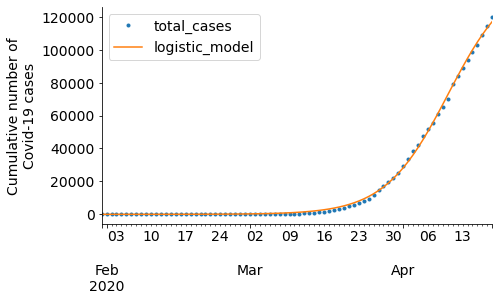

In [21]:
fig, ax = plt.subplots(figsize=default_figsize)
df[['total_cases', 'logistic_model']].plot(ax=ax, style=['.', '-'])
ax.set_ylabel('Cumulative number of\nCovid-19 cases');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(None);

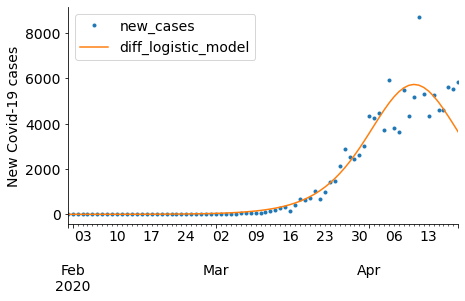

In [22]:
fig, ax = plt.subplots(figsize=default_figsize)
df[['new_cases', 'diff_logistic_model']].plot(ax=ax, style=['.', '-'])
ax.set_ylabel('New Covid-19 cases');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(None);

The fit looks good. As this is not a linear model we can't report an $r^2$ value, so we report root mean square error ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) instead.

In [23]:
def rmse(data: np.array, model: np.array) -> float:
    return np.sqrt(np.power(data - model, 2).sum() / data.size)

In [24]:
error = rmse(data=df['total_cases'].values,
             model=df['logistic_model'].values)

print(f'RMSE for logistic growth model is {round(error, 6)}, '
      f'or {round(error / UK_POP, 6) * 100}% of the UK population.')

RMSE for logistic growth model is 906.545753, or 0.0014% of the UK population.


In [25]:
print('New cases on 16th April: ', int(df['total_cases'].diff().loc['2020-04-16']))

New cases on 16th April:  4617


An RMSE of 721 seems quite large given the apparent goodness of fit. However, considering that the number of new cases on 16th April was 4617, an RMSE of ~16% of a day's change may not be too bad.

TODO: Read about model evaluation for logistic growth models. I suspect there is a better metric than RMSE.

# Fit exponential growth model

## Define exponential growth

Given the logistic growth model suggests the midpoint of the curve, and therefore the maximum slope, will occur on 9th April, any exponential growth should be expected to end before that point.

The expression for exponential growth is [given by][wiki-exp-growth]

$$x(t) = x_0 \, (1 + r_{\tau})^{t/\tau}$$
where $r_{\tau}$ is the proportion by which $x$ increases in a time step of duration $\tau$. Setting $\tau = 1 \text{ day}$ and $r = r_{1 \text{ day}}$ we have

$$x(t) = x_0 \, (1 + r)^t$$
where $t$ is the number of days since the initial count taken at $x_0$.

[wiki-exp-growth]: https://en.wikipedia.org/wiki/Exponential_growth#Basic_formula

Applying this formula to our problem, we model the cumulative number of cases $X_t$ with an exponential growth function $g(t)$

$$X_t = g(t) = X_0(1 + r)^t$$

In [26]:
t, X0, r = symbols('t X0 r')
g = X0 * (1 + r)**t

In [27]:
g

X0*(r + 1)**t

Similarly to for the logistic function, we can model the daily number of new cases $x_t$ using $g'(t)$

$$x_t = g'(t) = X_{0} \left(r + 1\right)^{t} \ln{\left(r + 1 \right)}$$

In [28]:
g.diff(t)

X0*(r + 1)**t*log(r + 1)

Taking (natural) logarithms of the above equation for $g(t)$ we can reformulate exponential growth as log-linear growth:

$$\ln(X_t) = \ln g(t) = \ln X_0 + t \, \ln(1 + r)\,.$$
Viewing the model like this, we see that exponential growth will appear as a straight line on a log-linear plot. That line's y-intercept will equal $\ln X_0$, and its slope $\ln(1 + r)$.



### Apply exponential growth model to UK cumulative cases data

Plot the UK confirmed cases data on log-linear axes to acertain if there is a period demonstrating exponential growth

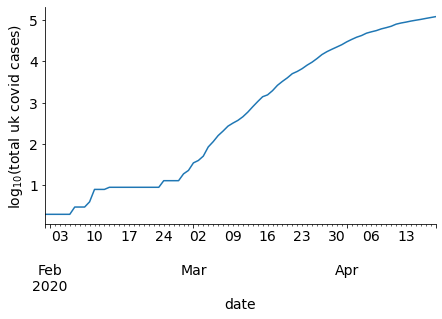

In [29]:
fig, ax = plt.subplots(figsize=(7, 4))
df.assign(log_cases=lambda df: np.log10(df['total_cases']))['log_cases'].plot(ax=ax)
ax.set_ylabel(r'$\log_{10}($total uk covid cases$)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

It looks to me like we saw exponential growth for the duration of March. The behaviour before the beginning of March is curious, but I don't have enough information to comment on why there appears to have been a plateau in mid-February. In any case we exclude dates before March as they don't correspond to the expected exponential growth pattern.

In [30]:
df_exp_growth = df['2020-03-01':'2020-03-31']

In [31]:
df_exp_growth.head()

,tests,total_cases,new_cases,n_days,logistic_model,diff_logistic_model
date,,,,,,
2020-03-01,11750,35,12.0,30,268.677189,42.138536
2020-03-02,13525,40,5.0,31,314.292389,49.277244
2020-03-03,13911,51,11.0,32,367.632444,57.619193
2020-03-04,16659,85,34.0,33,429.998346,67.364938
2020-03-05,18083,114,29.0,34,502.907552,78.747630


Create a new column containing $\log_{10}($total_cases$)$

In [32]:
df_exp_growth = (
    df_exp_growth.assign(log_total_cases=lambda df: (
        np.log(df['total_cases'])))
)

In [33]:
df_exp_growth.head()

,tests,total_cases,new_cases,n_days,logistic_model,diff_logistic_model,log_total_cases
date,,,,,,,
2020-03-01,11750,35,12.0,30,268.677189,42.138536,3.555348
2020-03-02,13525,40,5.0,31,314.292389,49.277244,3.688879
2020-03-03,13911,51,11.0,32,367.632444,57.619193,3.931826
2020-03-04,16659,85,34.0,33,429.998346,67.364938,4.442651
2020-03-05,18083,114,29.0,34,502.907552,78.747630,4.736198


Perform linear regression on the logged dependent variable

In [34]:
reg = LinearRegression().fit(
    df_exp_growth['n_days'].values.reshape(-1, 1),
    df_exp_growth['log_total_cases'].values
)

The linear model's intercept is $\ln X_0$, and the slope (i.e coefficient value) is $\ln(1 + r)$. Hence we find the optimal parameters as follows:

In [35]:
X0_opt = np.exp(reg.intercept_)
r_opt = np.exp(reg.coef_[0]) - 1

In [36]:
print(f'Optimal X0: {round(X0_opt, 3)}\nOptimal r: {round(r_opt, 3)}')

Optimal X0: 0.063
Optimal r: 0.248


I.e. from the optimal exponential growth model we infer that the number of infections increased at a rate of 25% per day.

In [37]:
def exp_func(t: float, X0: float, r: float) -> float:
    """Exponential growth function.
    
    g(t) = X0*(r + 1)**t
    
    Parameters
    ----------
    t: time of observation
    X0: function value at t=0 (y intercept of equivalent log-linear model)
    r: proportion by which function increases in a single time step    
    """
    return X0 * np.power((1 + r), t)

exp_func_v = np.vectorize(exp_func, excluded=['x0', 'r'])

In [38]:
def diff_exp_func(t: float, X0: float, r: float) -> float:
    """1st derivative of exponential growth function.
    
    g'(t) = X0*(r + 1)**t*log(r + 1)
    
    Parameters
    ----------
    t: time of observation
    X0: function value at t=0 (y intercept of equivalent log-linear model)
    r: proportion by which function increases in a single time step
    """
    return X0 * np.power(r + 1, t) * np.log(r + 1)

diff_exp_func_v = np.vectorize(diff_exp_func, excluded=['x0', 'r'])

In [39]:
log_yy_true = np.log(df_exp_growth['total_cases'])
log_yy_exp_model = np.log(X0_opt) + df_exp_growth['n_days'] * np.log(r_opt + 1)
exp_model_r2 = r2_score(log_yy_true, log_yy_exp_model)

In [40]:
exp_model_r2

0.9903149874858671

Plot log-linear model using parameters for the exponential model

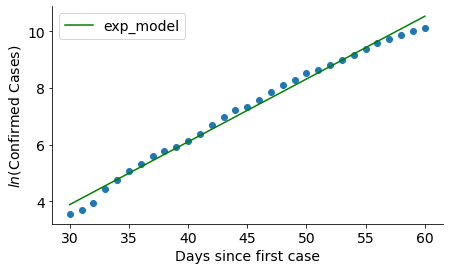

In [41]:
fig, ax = plt.subplots(figsize=(7, 4))
xx = df_exp_growth['n_days']
ax.scatter(xx,log_yy_true)
ax.plot(xx, log_yy_exp_model, ls='-', label='exp_model', c='g')
ax.set_ylabel(r'$ln$(Confirmed Cases)')
ax.set_xlabel('Days since first case')
ax.annotate(r'$r^2 = 0.99$', (50, 2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend();

Calculate values predicted by the exponential model for each of the days in the dataset until 2020-03-31

In [42]:
df_exp_growth = (
    df_exp_growth
    .assign(exp_model=lambda df: (exp_func_v(df['n_days'], X0_opt, r_opt)))
    .assign(diff_exp_model=lambda df: (diff_exp_func_v(df['n_days'], X0_opt, r_opt)))
)

Join exponential model back to original df

In [43]:
df = df.join(df_exp_growth[['exp_model', 'diff_exp_model']])

## Plot models

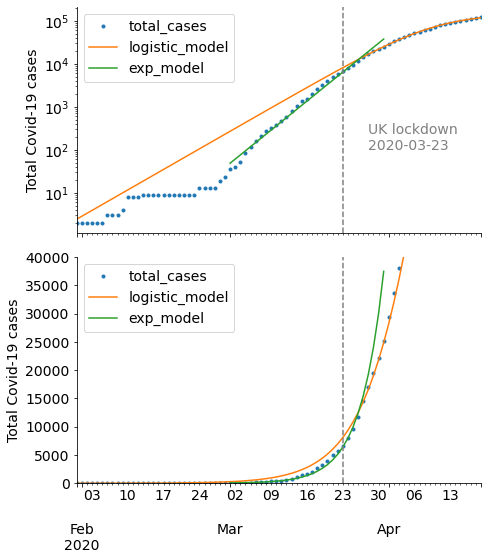

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=tall_figsize, sharex=True)
plot_df = df[['total_cases', 'logistic_model', 'exp_model']]
plot_df.plot(ax=axes[0], style=['.', '-', '-'])
axes[0].set_ylabel('Total Covid-19 cases');
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].axvline(UK_LOCKDOWN_DATE, ls='--', color='grey')
axes[0].annotate('UK lockdown\n' + UK_LOCKDOWN_DATE, ('2020-03-28', 100),
                 c='grey')
axes[0].set_yscale('log')

plot_df.plot(ax=axes[1], style=['.', '-', '-'])
axes[1].set_ylabel('Total Covid-19 cases');
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].axvline(UK_LOCKDOWN_DATE, ls='--', color='grey')
axes[1].set_ylim([0, 40000])
axes[1].set_xlabel(None)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'total_cases_models.png')

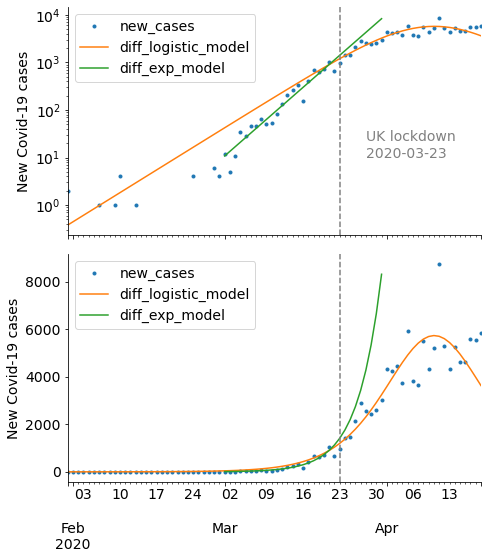

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=tall_figsize, sharex=True)
plot_df = df[['new_cases', 'diff_logistic_model', 'diff_exp_model']]
plot_df.plot(ax=axes[0], style=['.', '-', '-'])
axes[0].set_ylabel('New Covid-19 cases');
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].axvline(UK_LOCKDOWN_DATE, ls='--', color='grey')
axes[0].annotate('UK lockdown\n' + UK_LOCKDOWN_DATE, ('2020-03-28', 10),
                 c='grey')
axes[0].set_yscale('log')

plot_df.plot(ax=axes[1], style=['.', '-', '-'])
axes[1].set_ylabel('New Covid-19 cases');
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].axvline(UK_LOCKDOWN_DATE, ls='--', color='grey')
axes[1].set_xlabel(None)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'new_cases_models.png')

## Conclusions

- Evidence for logistic growth in cumulative confirmed cases. An RMSE value of 721 people seems high, but is small compared to the total number of cases at this stage.
- An exponential growth model fitted to the data for the period between 1st and 31st March was able to explain 99% of the variance in the data when reformulated as log-linear growth
- Visual inspection of the exponential model fit shows the increase in cases is slower than exponential after around 26th March. The logistic growth model continues to fit the data well after this point, however.
- Conclude that the number of Covid-19 cases in the UK grew exponentially between 1st March and 26th March.

## Limitations
- Data prior to 1st March excluded from exponential model fit due to possible artifacts in data. We should attempt to explain this.
- We should explore better ways of quantiying goodness of fit of the exponential model which does not depend on reformulating it in log-linear space as $r^2$ does.
- No attempt has been made to consider and represent model uncertainty/

## References

Bishop, C. M. (2006). [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf). New York: Springer.

Rogers, T. (2015). [Assessing node risk and vulnerability in epidemics on networks](https://arxiv.org/abs/1502.00901). EPL, 109(109). 

## Appendices

### A. Consideration of a possible statistical model
<a id='appendix-a'></a>

Here we discuss an obstacle to modelling the uncertainty in the number of new cases each day as a probability distribution. We use the example of a normal distribution, but the argument would apply equally to an attempt to estimate the parameters of other families of distribution from the data. To model the number of new cases per day as a normally distributed random variable we might:

1.  Assume each day's value is independent of, and identically distributed to, every other day's value (the observations are IID).
2.  Estimate the mean and variance for the distribution which we have assumed every day's observation has been drawn from by [maximum likelihood estimation](https://online.stat.psu.edu/stat414/node/191/) (see also section 2.3.4 of Bishop, 2006).
3.  Asses the goodness-of-fit between model and data, e.g. using a [Kolmogorov-Smirnov test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm).

This approach won't work with this data because we cannot make the assumption required by Step 1. To see why this is, let $x_t \geq 0$ be the number of new cases on day $t$. Because the total number of cases on day $t$ is given by $X_t = \sum_{t'=0}^{t} x_{t'}$, there cannot be fewer people to catch the disease from on day $t$ than there were on day $t-1$ (there's an extra day's worth of new cases in the sum). Therefore we should expect $x_t$ to depend on and so be correlated with $(x_0, \dots, x_{t-1})$. This in turn means the observations $(x_0,\dots, x_t)$ cannot be IID. The root of this problem is the fact that disease spread is an example of a non-equilibrium (i.e. irreversible) process (see e.g Rogers, 2015).

TODO: Find a better textbook discussion of disease spread as non-equilibrium process